loading data
loaded data
stock_id       0         1         2         3         4         5    \
stock_id                                                               
0         1.000000  0.185576  0.171927  0.446404  0.386700  0.251999   
1         0.185576  1.000000  0.122456  0.204489  0.210928  0.143170   
2         0.171927  0.122456  1.000000  0.196656  0.198224  0.163990   
3         0.446404  0.204489  0.196656  1.000000  0.472142  0.251108   
4         0.386700  0.210928  0.198224  0.472142  1.000000  0.273387   
...            ...       ...       ...       ...       ...       ...   
195       0.386545  0.147229  0.162142  0.459101  0.374227  0.208632   
196       0.300484  0.159527  0.172730  0.345715  0.309565  0.191027   
197       0.283733  0.160826  0.161474  0.313354  0.315239  0.287524   
198       0.387053  0.168845  0.164749  0.432174  0.377998  0.245230   
199       0.252995  0.151755  0.161476  0.314239  0.307176  0.184907   

stock_id       6         7         8  

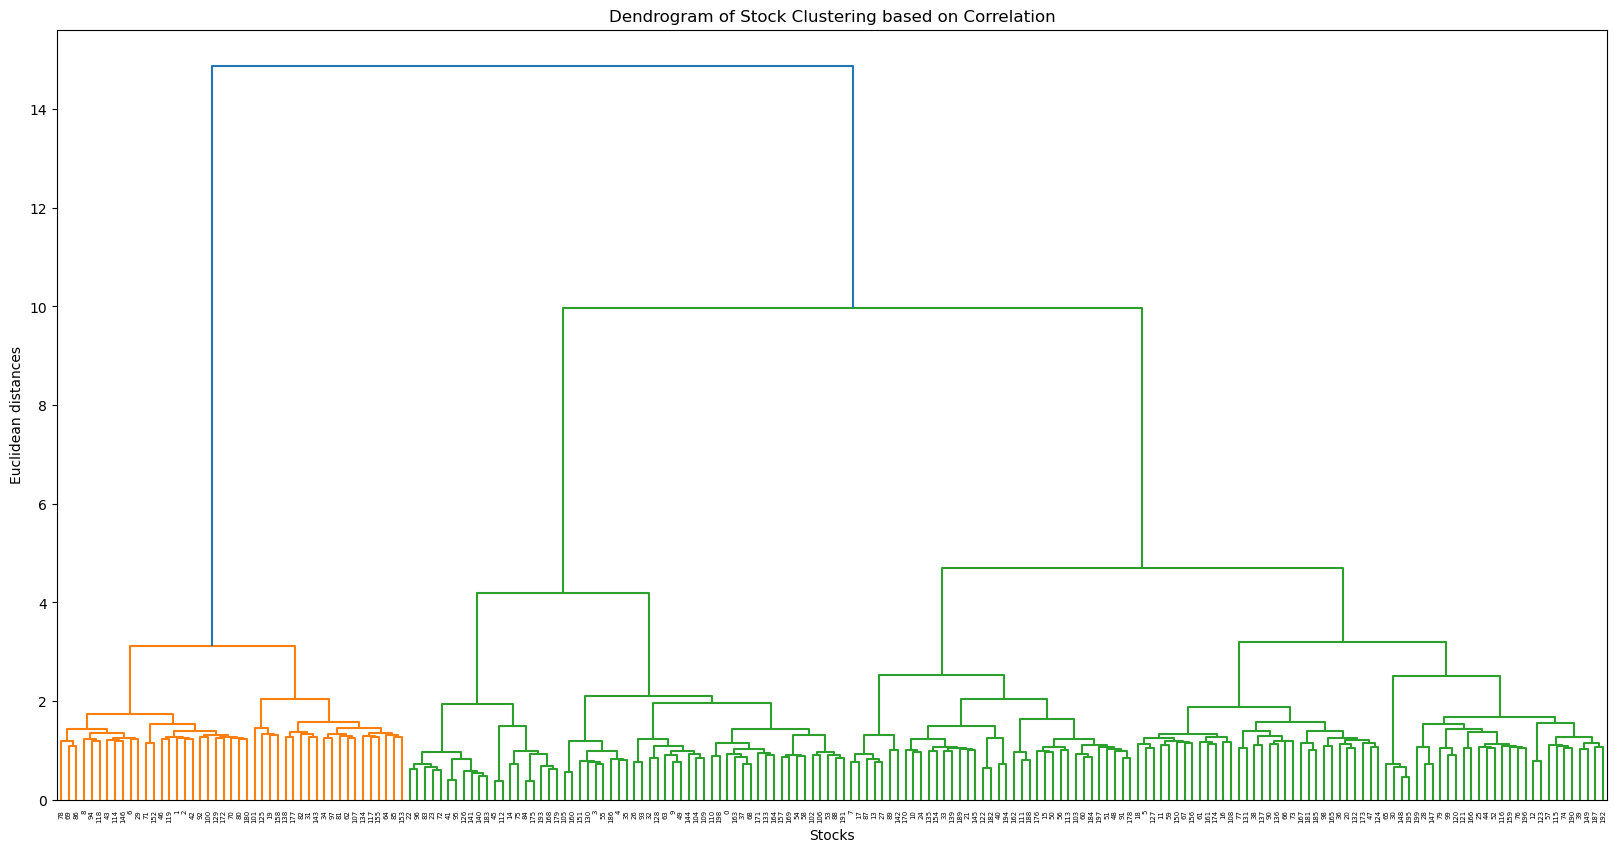

In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
from load_data import load_data_from_csv

# DATA_PATH = '/kaggle/input'
DATA_PATH = '..'
print("loading data")
result = load_data_from_csv(DATA_PATH)
df_train, *_ = result
print("loaded data")

# 1. Compute returns for each stock for each day
# Calculate daily returns
# def calculate_daily_returns(stock_data):
#     stock_data['return'] = stock_data['wap'].pct_change()
#     return stock_data[['return', 'seconds_in_bucket']].dropna()  # Keep 'return' and 'seconds_in_bucket' columns

# returns2 = df_train.groupby(['stock_id', 'date_id']).apply(calculate_daily_returns).reset_index()

df_train['return'] = df_train.groupby(['stock_id', 'date_id'])['wap'].pct_change()

df_train2 = df_train.dropna(subset=['return', 'seconds_in_bucket'])

# 2. Align the data for each stock by filling in the gaps (if any) and then concatenate the returns to form a matrix
# For this step, we will pivot the data so each stock has its own column, and each row represents a timestamp.
pivot_returns = df_train2.pivot_table(index=['date_id', 'seconds_in_bucket'], 
                                    columns='stock_id', 
                                    values='return')

# handle missing values by filling the average of all available 
pivot_returns = pivot_returns.apply(lambda row: row.fillna(row.mean()), axis=1)

# 3. Compute the correlation matrix for all stocks
correlation_matrix = pivot_returns.corr()

print(correlation_matrix)

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Hierarchical clustering
Z = linkage(correlation_matrix, 'ward')
clusters = fcluster(Z, 10, criterion = 'maxclust')

# Assign clusters to stocks
stock_clusters = pd.DataFrame({'stock_id': correlation_matrix.index, 'cluster': clusters})
print(stock_clusters)

plt.figure(figsize=(20, 10))
dendrogram(Z, labels=correlation_matrix.index, leaf_rotation=90)
plt.title('Dendrogram of Stock Clustering based on Correlation')
plt.xlabel('Stocks')
plt.ylabel('Euclidean distances')
plt.axhline(y=1500, color='r', linestyle='--') # This line represents the cut-off for the clusters. Adjust the value as needed.
plt.show()



    
class StockClustering:
    def __init__(self, data):
        self.data = data
        self.correlation_matrix = None
        self.stock_clusters = None
    
    def calculate_returns(self):
        self.data['return'] = self.data.groupby(['stock_id', 'date_id'])['wap'].pct_change()
        self.data = self.data.dropna(subset=['return', 'seconds_in_bucket'])
    
    def calculate_correlation_matrix(self):
        pivot_returns = self.data.pivot_table(index=['date_id', 'seconds_in_bucket'], 
                                              columns='stock_id', 
                                              values='return')
        
        pivot_returns = pivot_returns.apply(lambda row: row.fillna(row.mean()), axis=1)
        self.correlation_matrix = pivot_returns.corr()
    
    def perform_clustering(self, num_clusters):
        Z = linkage(self.correlation_matrix, 'ward')
        clusters = fcluster(Z, num_clusters, criterion='maxclust')
        self.stock_clusters = pd.DataFrame({'stock_id': self.correlation_matrix.index, 'cluster': clusters})
    
    def get_correlation_matrix(self):
        return self.correlation_matrix
    
    def get_stock_clusters(self):
        return self.stock_clusters
    
    def save_clusters_to_csv(self, filepath):
        self.stock_clusters.to_csv(filepath, index=False)
    
    
    
#to impose stocks PCA
from stocks_pca import StockClustering
clustering = StockClustering(df_train)
clustering.calculate_returns()
clustering.calculate_correlation_matrix()
clustering.perform_clustering(10)

stock_clusters = clustering.get_stock_clusters()

stock_clusters


output_filepath = 'output.csv'
stock_clusters.to_csv(output_filepath, index=False)


In [6]:
stock_clusters = pd.read_csv('stock_clusters.csv')
stock_clusters

,stock_id,cluster
0,0,5
1,1,1
2,2,1
3,3,4
4,4,4
...,...,...
195,195,9
196,196,10
197,197,7
198,198,5
